In [1]:
import gym
import scipy.optimize
import roboschool
from agent_file_random_mask import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
np.random.seed(0)
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace")

In [2]:
class adversial_env(object):
    def __init__(self, runst=True):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.env.seed(0)
        self.max_turn = 1000
        self.combine_ratio = 0.05
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.run_st = runst
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])-0.08#(np.abs(st[3])-0.00786861)*100
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
        
        final_r = r 
        
        self.total_score += final_r
        
        
        if self.run_st:
            self.obser_noise = self.obsr
        else:        
            self.obser_noise = (self.obsr*np.random.choice([0, 1],size = [1,5]))[0]
        
        return self.obser_noise, final_r, done, 0
    
    def non_adstep(self, a):
        self.epi_num = self.epi_num + 1
        ac = self.agent.act(a)
        self.obsr, r, done, _ = self.env.step(ac)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done:
            self.first = False
            self.run_avg = self.total_score
        
        final_r = r 
        
        self.total_score += final_r
        
        obser = (self.obsr)
        
        return obser, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fon_size = 19
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.plot(self.score_list[1:])
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('total reward',fontsize=fon_size)
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[1:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        plt.plot(self.epi_list)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('time steps',fontsize=fon_size)
        plt.show()

# performance in adversarial env without observer

In [3]:
env = adversial_env(runst=False)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        obs, r, done, _ = env.step(obs)
        if done:
            do = True

        score += r

[2018-02-15 03:05:14,896] Making new env: RoboschoolInvertedPendulum-v1


261.0 [261.0] [262]


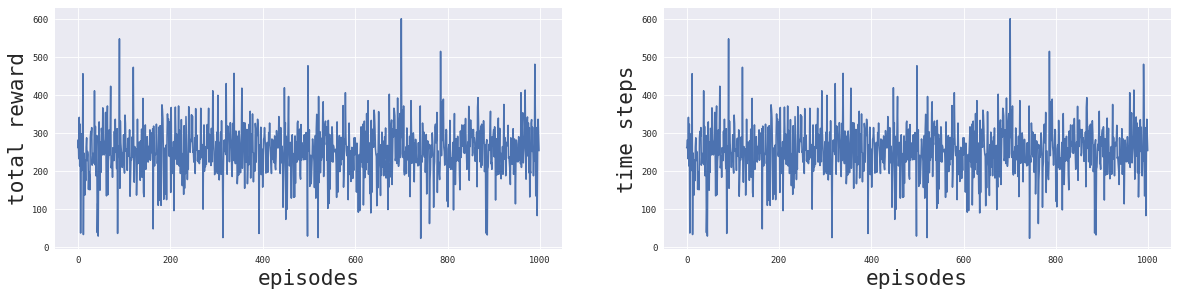

In [4]:
env.result_plot()

# define an observer (new agent)

In [5]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 55000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 999
        
args = par()
env = adversial_env()
agn = agent(env, args)
agn.learn()
agn.save_model('agent_model/random_mask_observer_2')

[2018-02-15 03:05:55,906] Making new env: RoboschoolInvertedPendulum-v1


16.0 [16.0] [17]
Episode 0	Last reward: 42.0	Average reward 21.41
('lagrange multiplier:', 0.9589827574803058, 'grad_norm:', 0.17061804656141025)
fval before -9.430762365687778e-15
a/e/r 0.019009916262673864 0.019179655149606074 0.9911500553264276
fval after -0.019009916262683293
Episode 1	Last reward: 69.0	Average reward 27.08
('lagrange multiplier:', 1.4613079139577791, 'grad_norm:', 0.24761853978083764)
fval before -4.3910065031703975e-16
a/e/r 0.031005646972890218 0.029226158279155517 1.060886849264888
fval after -0.031005646972890658
Episode 2	Last reward: 11.0	Average reward 37.71
('lagrange multiplier:', 1.4500729148063394, 'grad_norm:', 0.24934657795623913)
fval before 3.4161775218568566e-15
a/e/r 0.030782463974138904 0.02900145829612783 1.0614109007838708
fval after -0.030782463974135487
Episode 3	Last reward: 158.0	Average reward 60.87
('lagrange multiplier:', 1.4330729377079676, 'grad_norm:', 0.2511791713217973)
fval before -2.964551510193051e-15
a/e/r 0.02940931704582554 0.

In [6]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 55000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 900
        
args = par()
env = adversial_env(runst=False)
agn = agent(env, args)
agn.load_model('agent_model/random_mask_observer_2')

[2018-02-15 03:12:42,488] Making new env: RoboschoolInvertedPendulum-v1


# Agent training

In [7]:
agn.learn(run_state_update = False) # disable running state update

27.0 [27.0] [28]
Episode 0	Last reward: 94.0	Average reward 63.15
('lagrange multiplier:', 0.47515424793540006, 'grad_norm:', 0.18635317855065922)
fval before -7.753472874100304e-16
a/e/r 0.009781450549401306 0.009503077280261459 1.0292929606831724
fval after -0.009781450549402082
Episode 1	Last reward: 24.0	Average reward 92.19
('lagrange multiplier:', 0.6807978692541949, 'grad_norm:', 0.28149604498079067)
fval before 2.5641579572580656e-15
a/e/r 0.013948259293578395 0.013615983410377754 1.024403370155944
fval after -0.013948259293575831
Episode 2	Last reward: 275.0	Average reward 151.21
('lagrange multiplier:', 0.5433720844029448, 'grad_norm:', 0.15687183042592254)
fval before -5.120942751404994e-15
a/e/r 0.010699455399141359 0.010867694406071942 0.9845193469153323
fval after -0.01069945539914648
Episode 3	Last reward: 155.0	Average reward 180.06
('lagrange multiplier:', 0.42383610079731526, 'grad_norm:', 0.09019989794979946)
fval before -2.0174562453787996e-16
a/e/r 0.00802001140370

a/e/r 0.004901110105779219 0.005132870755895121 0.9548477526246449
fval after -0.004901110105779188
Episode 31	Last reward: 915.0	Average reward 690.54
('lagrange multiplier:', 0.2417878408363224, 'grad_norm:', 0.08132494082550855)
fval before 1.2095067441727488e-16
a/e/r 0.0047360928427696205 0.004837339738334173 0.9790697157856812
fval after -0.0047360928427695
Episode 32	Last reward: 208.0	Average reward 666.52
('lagrange multiplier:', 0.2768278792315558, 'grad_norm:', 0.04319382155593276)
fval before -4.1327967301225165e-16
a/e/r 0.005597182078040478 0.005544148683969598 1.0095656514812132
fval after -0.005597182078040891
Episode 33	Last reward: 1000.0	Average reward 691.86
('lagrange multiplier:', 0.27137623282301854, 'grad_norm:', 0.09838862177928814)
fval before -6.187500880339856e-16
a/e/r 0.005366055948232443 0.005416029618044231 0.990773006549799
fval after -0.005366055948233061
Episode 34	Last reward: 1000.0	Average reward 674.54
('lagrange multiplier:', 0.2308013046874656, 

fval before -2.6095579075302963e-16
a/e/r 0.004987591505955459 0.005266301411753718 0.9470767272879191
fval after -0.0049875915059557204
Episode 62	Last reward: 1000.0	Average reward 744.52
('lagrange multiplier:', 0.22498831207171513, 'grad_norm:', 0.05306183250524669)
fval before 8.061190621322436e-17
a/e/r 0.00441958393525947 0.004499217032902411 0.9823006765264733
fval after -0.004419583935259389
Episode 63	Last reward: 961.0	Average reward 756.90
('lagrange multiplier:', 0.2893594506886382, 'grad_norm:', 0.08851816204729693)
fval before 6.0836822000376764e-18
a/e/r 0.00561119924505841 0.005789138309161514 0.9692632902168689
fval after -0.005611199245058404
Episode 64	Last reward: 774.0	Average reward 769.61
('lagrange multiplier:', 0.2788465579801814, 'grad_norm:', 0.12268018810437199)
fval before 2.471754924545797e-16
a/e/r 0.005734201454801317 0.005577743985670013 1.0280503138066688
fval after -0.00573420145480107
Episode 65	Last reward: 1000.0	Average reward 752.65
('lagrange m

('lagrange multiplier:', 0.26200675589204897, 'grad_norm:', 0.13279370157128373)
fval before -4.180789199041055e-16
a/e/r 0.005177872874411773 0.005243147341539386 0.9875505182525638
fval after -0.005177872874412191
Episode 93	Last reward: 1000.0	Average reward 824.56
('lagrange multiplier:', 0.23190220063564518, 'grad_norm:', 0.06704733941756014)
fval before 3.767352836762632e-16
a/e/r 0.004539715681222308 0.004637908009591622 0.9788283147992062
fval after -0.004539715681221932
Episode 94	Last reward: 393.0	Average reward 748.57
('lagrange multiplier:', 0.26330833621183386, 'grad_norm:', 0.13233498267979196)
fval before -1.3648704348027015e-16
a/e/r 0.005220172687505207 0.005265258147831983 0.9914371795150556
fval after -0.005220172687505343
Episode 95	Last reward: 896.0	Average reward 825.01
('lagrange multiplier:', 0.257583154389714, 'grad_norm:', 0.09980574757215878)
fval before -5.265505248855399e-17
a/e/r 0.006277892838006208 0.005150358559718736 1.2189234526516244
fval after -0.

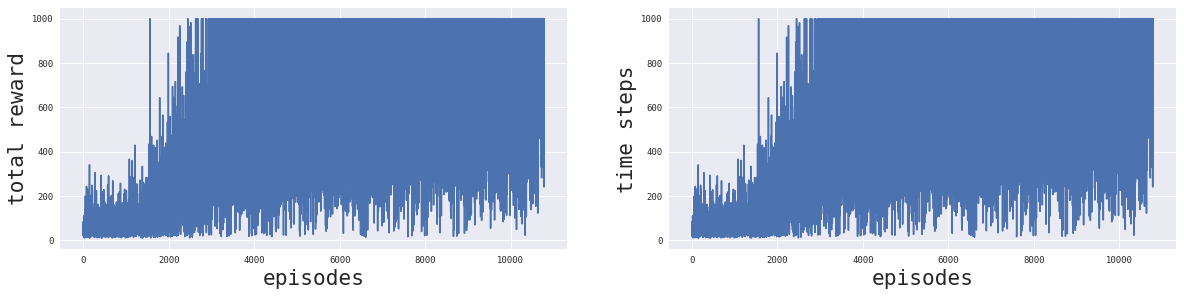

In [8]:
env.result_plot()

# Agent evaluation

In [9]:
env = adversial_env(runst=False)
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-02-15 05:00:25,591] Making new env: RoboschoolInvertedPendulum-v1


999.0 [999.0] [1000]


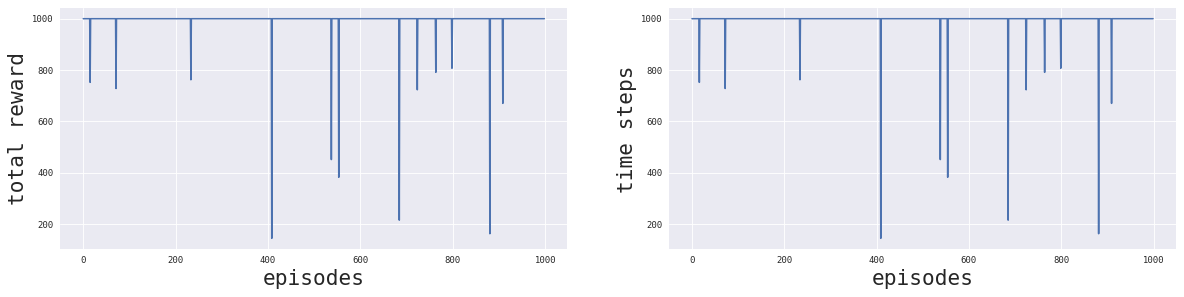

In [10]:
env.result_plot()

# Performance on non_adversarial environment with observer

In [11]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    while done == False:   
        a = agn.select_action_deterministic(obs)
        
        obs, r, done, _ = env.non_adstep(a)
        if done:
            do = True

        score += r

[2018-02-15 05:08:23,014] Making new env: RoboschoolInvertedPendulum-v1


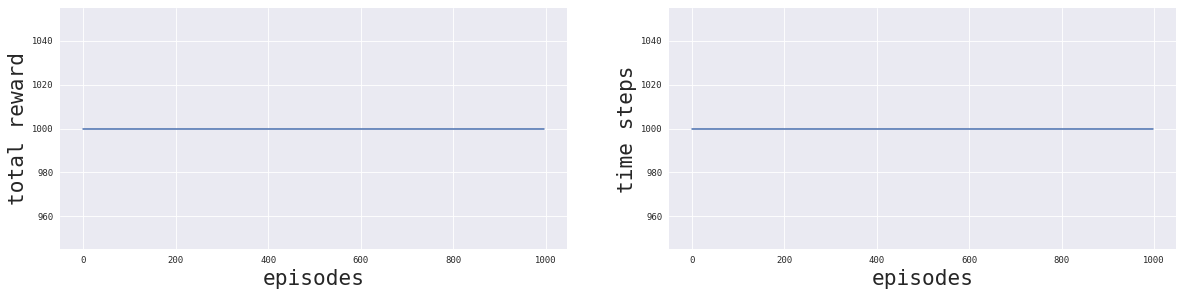

In [12]:
env.result_plot()